In [1]:
import sys
import subprocess
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
import GCRCatalogs

In [45]:
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import FlatLambdaCDM

DC2 = FlatLambdaCDM(H0=71, Om0=0.265, Ob0=0.0448)

In [51]:
def get_smass(catalog_name):
    
    '''
    Parameter
    -----------
    catalog_name = version of the catalogue to use
    
    Return
    -----------
    - log10 of totall stellar mass with no cuts applied
    - log10 of stellar mass in protoDCa2 catalogue with CMASS color and magnitude cuts applied
    - redshift
    '''
    
    gc         = GCRCatalogs.load_catalog(catalog_name)
    data       = gc.get_quantities(['stellar_mass', 'mag_true_i_lsst', 'mag_true_r_lsst', 'mag_true_g_lsst', 'x','y','z'])
    smass      = data['stellar_mass']
    x, y, z    = data['x'], data['y'], data['z']
    log10smass = np.log10(smass)
    
    # calculating the reshifts
    com_dist = np.sqrt((x**2) + (y**2)+(z**2))
    
    min_indx = np.where(com_dist == np.min(com_dist ))[0][0]
    max_indx = np.where(com_dist == np.max(com_dist ))[0][0]

    zmin = z_at_value(DC2.comoving_distance, com_dist[min_indx] * u.Mpc)
    zmax = z_at_value(DC2.comoving_distance, com_dist[max_indx] * u.Mpc)

    zgrid     = np.logspace(np.log10(zmin), np.log10(zmax), 50)
    cosmology = DC2
    CDgrid = cosmology.comoving_distance(zgrid)*DC2.H0/100.
    #  use interpolation to get redshifts for satellites only
    new_redshifts = np.interp(com_dist, CDgrid, zgrid)
    
    
    print 
    print ("minimum total = ", np.min(log10smass))
    print ("maximum total = ", np.max(log10smass))
    print
    
    r = data['mag_true_r_lsst']
    i = data['mag_true_i_lsst']
    g = data['mag_true_g_lsst']
    
    # applying CMASS cuts
    dperp = (r-i) - (g-r)/8.
    cond1 = dperp > 0.55
    cond2 = i < (19.86 + 1.6*(dperp - 0.8))
    cond3 = (i < 19.9) & (i > 17.5)
    cond4 = (r-i) < 2
    cond5 = i < 21.5
    
    #cond6 = new_redshifts < 0.2
    
    smass_cmass_cut = smass[np.where( (cond1==True) & (cond2==True) & (cond3==True) & (cond4==True) & (cond5==True))]
    
    print 
    print ("minimum cmass-cut = ", np.min(np.log10(smass_cmass_cut)))
    print ("maximum cmass-cut = ", np.max(np.log10(smass_cmass_cut)))
    print
    
    return np.log10(smass), np.log10(smass_cmass_cut), new_redshifts

In [52]:
log_smass_tot_test, log_smass_cmass_test, redshift_test = get_smass('cosmoDC2_v0.1_test')
log_smass_tot_actual, log_smass_cmass_actual, redshift_actual = get_smass('cosmoDC2_v0.1')

minimum total =  3.84628
maximum total =  12.637
minimum cmass-cut =  9.67139
maximum cmass-cut =  12.637
minimum total =  3.57428
maximum total =  12.661
minimum cmass-cut =  9.52519
maximum cmass-cut =  12.661


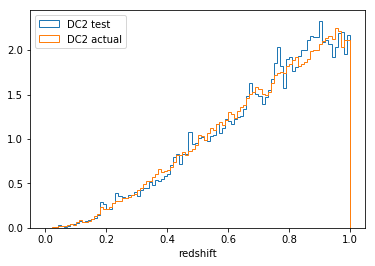

In [61]:
fig, ax = plt.subplots()
_ = ax.hist(redshift_test, bins=np.arange(0., 1.01, 0.01), normed=True, histtype='step', label="DC2 test")
_ = ax.hist(redshift_actual, bins=np.arange(0., 1.01, 0.01), normed=True, histtype='step', label="DC2 actual")
plt.legend(loc='upper left')
plt.xlabel("redshift")
plt.savefig("redshifts_test_actual_DC2.png")

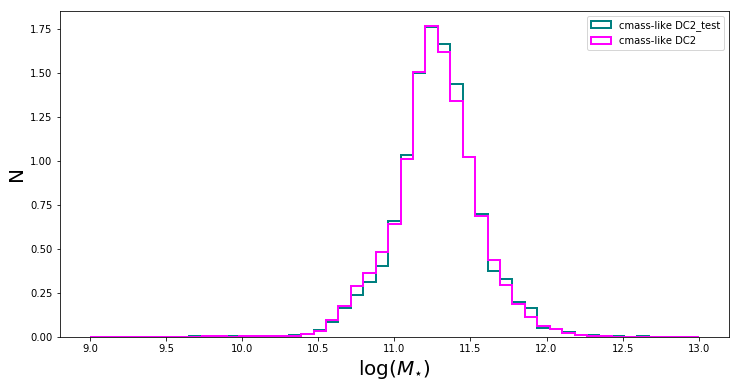

In [48]:
plt.figure(1, figsize=(12,6))
plt.hist(log_smass_cmass_test, bins=np.linspace(9,13,50), color="teal", linewidth=2, histtype = "step", normed = "True", label="cmass-like DC2_test")
plt.hist(log_smass_cmass_actual, bins=np.linspace(9,13,50), color="magenta", linewidth=2, histtype = "step", normed = "True", label="cmass-like DC2")
plt.legend(loc='best')
plt.xlabel(r"$\log(M_{\star})$", fontsize=20)
plt.ylabel("N", fontsize=20)
plt.savefig("Mstellar_DC2test_DC2_comparison_cmasslike.png")